## This notebook uses RDMC to generate initial TS guess from user-provided atom-mapped reaction smiles

### currently implemented for bi-molecular H abstraction reactions

todo:

In [22]:

import os
import re
import sys
import json

from itertools import chain
from rdmc import RDKitMol
from rdmc.ts import get_formed_and_broken_bonds
from rdmc.view import ts_viewer
from rdmc.view import mol_viewer
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole

from rdmc.forcefield import RDKitFF

import numpy as np
import pandas as pd
import json
import copy

from typing import Optional, Sequence, Union, List, Tuple

from rdkit.Chem import FragmentMatcher, MolFromSmiles, MolFromSmarts
from rdkit import Chem

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
# useful if you are opening this notebook in a browser
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Function to generate a bi-habs TS example
# Use R1H + R2OO* = R1* + R2OOH as demo

In [24]:
# here we pick a force field for embedding initial reactant/product geometry
FF = AllChem.ETKDGv3()
FF.randomSeed=np.random.randint(1,10000000) # this make sure we get different embedding each time

In [25]:
# SMARTS patterns for substructure match
ROO_GROUP = '[H,C,N,O]-[O;X2]-[O;X1+0]' # match ROO radical, with R = H, C, O, N only
ROOH_GROUP = '[*]-[O;X2]-[OH]' # match any ROOH group
NONE_GROUP = '[Xe]' # using Xe as a None group that will match nothing; use when you do not care what the species is
RADICAL_GROUP = '[CX3+0,NX2+0,OX1+0]' # match radical, with R = C, O, N only

In [26]:
# Empirical parameters 
EMPIRICAL_PARA_TS_GUESS = {
        'angle_X_H_Y': 175, # initial angle for TS pivot. Do not make it too close to 180.
        'dihedral_r1': 90, # initial dihedral angle for TS, defined using r1, does not really matter most of the time for bi-molecular H abstraction.
        'dihedral_r2': 90, # the other diehdral angle, defined using reactant 2 or r2
        'bond_length_scale_factor_r1': 1.2, # how much to scale the TS bond length based on reactant bond length for r1; can be modified to scale each bond differently, but usually 1.2-1.25 is good guess for bi-molecular H abstraction with C-H and 1.15 - 1.2 for O-H. 
        'bond_length_scale_factor_r2': 1.2, # how much to scale the TS bond length based on reactant bond length for r1; can be modified to scale each bond differently, but usually 1.2-1.25 is good guess for bi-molecular H abstraction with C-H and 1.15 - 1.2 for O-H. 
        'bond_length_X_H': None, # directly specifiy the TS bond length for r1, useful if another bond length estimater e.g., TS-EGNN/Chemprop/Kinbot can provide this information   
        'bond_length_H_Y': None, # directly specifiy the TS bond length for r2
}

# Utility functions

In [27]:
def adjust_atom_map_smi_indexing(rxn_smi: str,
                                 mode: str,
                                ) -> str:
    """
    Helper function to adjust the indexing of atom mapped smiles. Useful for converting the smi to zero- or one- indexing. 

    Args:
        rxn_smi (str): input atom-mapped reaction smiles
        mode (str): plus_one: increase all indexing by 1
                    minus_one: reduce all indexing by 1

    Returns:
        str: re-numbered smi string
    """

    def decrement(m):
        return str(int(m.group().rstrip(']')) - 1) + "]"
    
    def increment(m):
        return str(int(m.group().rstrip(']')) + 1) + "]"

    # Use a regular expression to find all the integers and decrement or increment each one
    # Note we search for "{number}]" to ensure that the number corresponds to an atom index.
    # Sometimes, SMILES strings include numbers to indicate connectivity i.e. in rings.
    if mode == 'plus_one':
        new_smi = re.sub(r'\d+]', lambda m: increment(m), rxn_smi)
    elif mode == 'minus_one':
        new_smi = re.sub(r'\d+]', lambda m: decrement(m), rxn_smi)
    else:
        raise ValueError(f'Specificed mode {mode} not recongized. Must be either plus_one or minus_one')
    
    return new_smi

In [28]:
def test_adjust_atom_map_smi_indexing():
    zero_idx_smi = '[H:10][C:15]([H:11])([H:12])[C:16]([H:13])([H:14])[F:17].[H:0][C:5]([H:1])([H:2])[S:9][C:6]([H:3])([H:4])[O:8][O:7]>>[H:11][C:15]([H:12])[C:16]([H:13])([H:14])[F:17].[H:0][C:5]([H:1])([H:2])[S:9][C:6]([H:3])([H:4])[O:8][O:7][H:10]'
    one_idx_smi = '[H:11][C:16]([H:12])([H:13])[C:17]([H:14])([H:15])[F:18].[H:1][C:6]([H:2])([H:3])[S:10][C:7]([H:4])([H:5])[O:9][O:8]>>[H:12][C:16]([H:13])[C:17]([H:14])([H:15])[F:18].[H:1][C:6]([H:2])([H:3])[S:10][C:7]([H:4])([H:5])[O:9][O:8][H:11]'
    assert adjust_atom_map_smi_indexing(rxn_smi=zero_idx_smi, mode='plus_one') == one_idx_smi
    assert adjust_atom_map_smi_indexing(rxn_smi=one_idx_smi, mode='minus_one') == zero_idx_smi
    
    zero_idx_smi = '[C:0]([C:1]([C:2]([C:3]([Br:4])([H:22])[H:23])([H:20])[H:21])([H:18])[H:19])([H:15])([H:16])[H:17].[c:5]1([H:24])[c:6]([H:25])[c:7]([S-:8])[c:9]([H:26])[c:10]([H:27])[c:11]1[N+:12](=[O:13])[O-:14]'
    one_idx_smi  = '[C:1]([C:2]([C:3]([C:4]([Br:5])([H:23])[H:24])([H:21])[H:22])([H:19])[H:20])([H:16])([H:17])[H:18].[c:6]1([H:25])[c:7]([H:26])[c:8]([S-:9])[c:10]([H:27])[c:11]([H:28])[c:12]1[N+:13](=[O:14])[O-:15]'
    assert adjust_atom_map_smi_indexing(rxn_smi=zero_idx_smi, mode='plus_one') == one_idx_smi
    assert adjust_atom_map_smi_indexing(rxn_smi=one_idx_smi, mode='minus_one') == zero_idx_smi
    
    
test_adjust_atom_map_smi_indexing()

In [29]:
def determine_atom_map_smi_indexing(rxn_smi: str,
                                   ) -> int:
    """
    Helper function to determine the starting index of an atom mapped reaction smile. Expect either zero- or one- indexing. 

    Args:
        rxn_smi (str): input atom-mapped reaction smiles

    Returns:
        int: starting index
    """
    
    # Extract all integers from the string
    integers = [int(match.rstrip("]")) for match in re.findall(r'\d+]', rxn_smi)]
    
    # Return the smallest integer if there's any integer in the string
    return min(integers) if integers else None

In [30]:
def test_determine_atom_map_smi_indexing():
    zero_idx_smi = '[H:10][C:15]([H:11])([H:12])[C:16]([H:13])([H:14])[F:17].[H:0][C:5]([H:1])([H:2])[S:9][C:6]([H:3])([H:4])[O:8][O:7]>>[H:11][C:15]([H:12])[C:16]([H:13])([H:14])[F:17].[H:0][C:5]([H:1])([H:2])[S:9][C:6]([H:3])([H:4])[O:8][O:7][H:10]'
    one_idx_smi = '[H:11][C:16]([H:12])([H:13])[C:17]([H:14])([H:15])[F:18].[H:1][C:6]([H:2])([H:3])[S:10][C:7]([H:4])([H:5])[O:9][O:8]>>[H:12][C:16]([H:13])[C:17]([H:14])([H:15])[F:18].[H:1][C:6]([H:2])([H:3])[S:10][C:7]([H:4])([H:5])[O:9][O:8][H:11]'
    
    assert determine_atom_map_smi_indexing(rxn_smi=zero_idx_smi) == 0
    assert determine_atom_map_smi_indexing(rxn_smi=one_idx_smi) == 1
    
    two_idx_smi = '[C:2]([C:3]([C:4]([C:5]([Br:6])([H:24])[H:25])([H:22])[H:23])([H:20])[H:21])([H:17])([H:18])[H:19].[c:7]1([H:26])[c:8]([H:27])[c:9]([S-:10])[c:11]([H:28])[c:12]([H:29])[c:13]1[N+:14](=[O:15])[O-:16]'
    assert determine_atom_map_smi_indexing(rxn_smi=two_idx_smi) == 2
    
test_determine_atom_map_smi_indexing()

In [31]:
def split_rxn_smi(rxn_smi: str,
                  ) -> Union[List[str], List[str]]:
    """
    Split a given reaction smile into reactant and product smiles in lists.

    Args:
        rxn_smi (str): input reaction smiles

    Returns:
        Union[List[str], List[str]]: smiles of individual reactants and products, in sepearte lists
    """
    
    reactants = rxn_smi.split(">>")[0].split('.')
    products = rxn_smi.split(">>")[1].split('.')
    
    return reactants, products

In [32]:
def reorder_reaction_smile(rxn_smi: str,
                           r_pattern: Optional[List[str]] = [],
                           p_pattern: Optional[List[str]] = [],
                          ) -> str:
    
    """
    Preprocess a reaction smile to a specified order by user.  

    This function will seperate a reaction smile into speices, then reorder them into reactants and products based on SMARTS patterns specified by user, and finally return the ordered new reaction smile.
    
    Note: use NONE_GROUP if you do not care about which species to be matched in a particular position. Do not use a wild card [*] for this purpose, for it will match any species and the logic in this function does not work well with it. 
          Make sure to test this function. It is common to make mistakes in SMARTS.
    
    Input:
        rxn_smi: atom-mapped reaction smiles
        r_pattern (optional): SMARTS pattern for matching reactants, length must match number of reactants in rxn_smi
        p_pattern (optional): SMARTS pattern for matching products, length must match number of products in rxn_smi
    
    Output:
        New reaction smiles with species match the order of the pattern specified.
    """

    # return original smile if no pattern to match
    if not any([len(r_pattern), len(p_pattern)]):
        return rxn_smi
    
    # get reactants and products from provided smi
    _reactants, _products = split_rxn_smi(rxn_smi=rxn_smi)
    
    # raise if provided number of patterns mismatch given smi
    if not all([len(_reactants) == len(r_pattern), len(_products) == len(p_pattern)]):
        raise ValueError('Provided number of patterns does not equal to number of species in the given reaction.')
    
    # turn smi into rdkit molecule for matching 
    _r_mols = [MolFromSmiles(smi) for smi in _reactants]
    _p_mols = [MolFromSmiles(smi) for smi in _products]
    
    reactants = []
    products = []

    # match reactant pattern 
    for pattern in r_pattern:
        patt = Chem.MolFromSmarts(pattern) # turn pattern into rdkit molecule for substructure matching
        try:
            matched_idx = [bool(x) for x in [mol.GetSubstructMatch(patt) for mol in _r_mols]].index(True) # return species index of the first match 
        except ValueError:
            if NONE_GROUP in r_pattern: # NONE_group means the user does not care about which species get matched in the current index
                reactants.append(None) # place holder for index/order keeping, will be replaced by leftover species later
                continue
            else:
                raise ValueError(f'Pattern {pattern} not found in provided reaction species.')
            
        reactants.append(_reactants[matched_idx]) # add matched species to new reactants list
        _r_mols.pop(matched_idx) 
        _reactants.pop(matched_idx)
    else:
        if reactants == [None, None]: # this means the user does not care about species order
            reactants = _reactants # so we leave order unchanged 
        elif None in reactants: # one of the species can be any left over species 
            reactants[reactants.index(None)] = _reactants[0] # replace the place holder with left over species
                
    # match product pattern, same logic as reactant
    for pattern in p_pattern:
        patt = Chem.MolFromSmarts(pattern)
        try:
            matched_idx = [bool(x) for x in [mol.GetSubstructMatch(patt) for mol in _p_mols]].index(True)
        except ValueError:
            if NONE_GROUP in p_pattern:
                products.append(None)
                continue
            else:
                raise ValueError(f'Pattern {pattern} not found in provided reaction species.')   
        products.append(_products[matched_idx])
        _p_mols.pop(matched_idx)
        _products.pop(matched_idx)
    else:
        if products == [None, None]:
            products = _products
        elif None in products:
            products[products.index(None)] = _products[0]
        
    ordered_rxn_smi = ".".join(reactants) + ">>" + ".".join(products)
    return ordered_rxn_smi

In [33]:
def test_reorder_reaction_smile():
    input_rxn_smi = '[H:1][C:6]([H:2])([H:3])[S:10][C:7]([H:4])([H:5])[O:9][O:8].[H:11][C:16]([H:12])([H:13])[C:17]([H:14])([H:15])[F:18]>>[H:1][C:6]([H:2])([H:3])[S:10][C:7]([H:4])([H:5])[O:9][O:8][H:11].[H:12][C:16]([H:13])[C:17]([H:14])([H:15])[F:18]'
    expected_rxn_smi = '[H:11][C:16]([H:12])([H:13])[C:17]([H:14])([H:15])[F:18].[H:1][C:6]([H:2])([H:3])[S:10][C:7]([H:4])([H:5])[O:9][O:8]>>[H:12][C:16]([H:13])[C:17]([H:14])([H:15])[F:18].[H:1][C:6]([H:2])([H:3])[S:10][C:7]([H:4])([H:5])[O:9][O:8][H:11]'
    
    r_pattern = [NONE_GROUP, ROO_GROUP]
    p_pattern = [RADICAL_GROUP, ROOH_GROUP]

    assert reorder_reaction_smile(rxn_smi=input_rxn_smi, r_pattern=r_pattern, p_pattern=p_pattern) == expected_rxn_smi
    
test_reorder_reaction_smile()

In [34]:
def isomorphic_check(mol1: RDKitMol, 
                     mol2: RDKitMol,
                     ) -> bool: 
    """
    Compare if two rdkit molecules are the same.

    Args:
        mol1 (RDKitMol)
        mol2 (RDKitMol) 

    Returns:
        bool: True if the same.
    """
    
    return mol1.HasSubstructMatch(mol2) and mol2.HasSubstructMatch(mol1)

In [35]:
def test_isomorphic_check():
    smi1 = 'c1ccc2c(c1)c3ccccc3[nH]2' 
    smi2 = 'C1=CC=C2C(=C1)C3=CC=CC=C3N2'
    mol1 = Chem.MolFromSmiles(smi1)
    mol2 = Chem.MolFromSmiles(smi2)
    
    assert isomorphic_check(mol1, mol2) == True
    
    smi1 = 'CCC' 
    smi2 = 'C1=CC=C2C(=C1)C3=CC=CC=C3N2'
    mol1 = Chem.MolFromSmiles(smi1)
    mol2 = Chem.MolFromSmiles(smi2)
    
    assert isomorphic_check(mol1, mol2) == False
    
    smi1 = '[H:10][C:15]([H:11])([H:12])[C:16]([H:13])([H:14])[F:17]'
    smi2 = '[H:20][C:45]([H:11])([H:12])[C:16]([H:13])([H:14])[F:17]'
    mol1 = Chem.MolFromSmiles(smi1)
    mol2 = Chem.MolFromSmiles(smi2)
    
    assert isomorphic_check(mol1, mol2) == True
    
test_isomorphic_check()

In [36]:
# Note that this was changed to fix a glitch.

def get_ordered_integers(rxn_smi: str,
                         sorted: bool = False, 
                         ) -> List[int]:
    """
    Get integers ordered by occurence from a string. Useful to extract atom mapping from smiles. 

    Args:
        rxn_smi (str): atom-mapped reaction smiles

    Returns:
        List[int]: extracted integer list
    """

    # Extract all integers from the string    
    int_list = [int(match.rstrip("]")) for match in re.findall(r'\d+\]', rxn_smi)]
    if sorted:
        int_list.sort()

    return int_list

In [37]:
def test_get_ordered_integers():
    smi1 = '[H:10][C:15]([H:11])([H:12])[C:16]([H:13])([H:14])[F:17]'
    assert get_ordered_integers(smi1) == [10, 15, 11, 12, 16, 13, 14, 17]
    
    smi2 = '[c:5]1([H:24])[c:6]([H:25])[c:7]([S-:8])[c:9]([H:26])[c:10]([H:27])[c:11]1[N+:12](=[O:13])[O-:14]'
    assert get_ordered_integers(smi2) == [5, 24, 6, 25, 7, 8, 9, 26, 10, 27, 11, 12, 13, 14]
    
test_get_ordered_integers()

In [38]:
def get_neighbour_atom(mol, center_atom_idx, exlude_atom_idx_list=None):
        
    neighbour = {nb.GetIdx():mol.GetAtomWithIdx(nb.GetIdx()).GetSymbol() for nb in mol.GetAtomWithIdx(center_atom_idx).GetNeighbors()}
    
    if exlude_atom_idx_list:
        for x in exlude_atom_idx_list:
            try:
                del neighbour[x]
            except:
                pass
            
    return neighbour

In [39]:
def find_fragment(mol, center_atom_idx, exlude_atom_idx_list):
    frag = dict()
    max_frag_size = len(mol.GetAtomicNumbers())
    center_atom = {center_atom_idx: mol.GetAtomWithIdx(center_atom_idx).GetSymbol()}
    
    frag = get_neighbour_atom(mol, center_atom_idx, exlude_atom_idx_list)
    
    search_list = list(frag.keys())
    to_exlude = list()
    to_exlude.append(center_atom_idx)
        
    while search_list:
        for k in search_list:
            if mol.GetAtomWithIdx(k).GetSymbol() == 'H':
                to_exlude.append(k)
                search_list = list(set([x for x in search_list if x not in to_exlude]))
            neighbour = get_neighbour_atom(mol, k, to_exlude)
            search_list.extend(list(neighbour.keys()))
            to_exlude.append(k)
            search_list = list(set([x for x in search_list if x not in to_exlude]))
            frag.update(neighbour)

            if len(frag.keys()) >= max_frag_size:
                frag.update(center_atom)
                return frag
    else:
        frag.update(center_atom)
        return frag

In [40]:
def perceive_rxn_generate_complex(rxn_smi: str,
                                 ) -> dict:
    """
    perceive_rxn_generate_complex _summary_

    _extended_summary_

    Args:
        rxn_smi (str): _description_

    Returns:
        dict: _description_
    """

    # generate reactant and product complex RDkitMOl from smiles, atoms are always zero-indexed, use mol.GetAtomMapNumbers() to get atom map specified in the smiles
    r_complex, p_complex = [RDKitMol.FromSmiles(smi) for smi in rxn_smi.split(">>")]
    
    # perceive reaction center
    fbond, bbond = get_formed_and_broken_bonds(r_complex, p_complex) # formed, broken bonds indices e.g., fbond = [(1, 3)] means a bond forms between atom with index 1 and 3, notice that atoms are zero-indexed and reaction is analyzed in the forward direction
    the_h_atom = list(set(chain(*fbond)).intersection(chain(*bbond))) # the H atom index in the TS
    
    _pivot_atoms = list(set(chain(*(fbond+bbond))).difference(the_h_atom)) # TS pivot atom indices, not yet sorted by given reactants order
    pivot_atoms = [None] * len(_pivot_atoms)
    
    # get atom indices in each molecule fragments, re-arranged to match the reactants and products order specified in the reaction smile
    _frags_r = r_complex.GetMolFrags(asMols=False) # reactants complex
    _frags_p = p_complex.GetMolFrags(asMols=False) # products complex
    
    frags_r = [None] * len(_frags_r)
    frags_p = [None] * len(_frags_p)
    
    _reactants, _products = split_rxn_smi(rxn_smi=rxn_smi)
    _reactants_atom_map = [get_ordered_integers(x, sorted=True) for x in _reactants]
    _products_atom_map = [get_ordered_integers(x, sorted=True) for x in _products]
    
    r_complex_atom_map = r_complex.GetAtomMapNumbers()
    _frags_r_atom_map = [[r_complex_atom_map[i] for i in x] for x in _frags_r]

    for i, x in enumerate(_frags_r_atom_map):
        idx = _reactants_atom_map.index(x)
        frags_r[idx] = _frags_r[i]
    else:
        frags_r = tuple(frags_r)
        
    p_complex_atom_map = p_complex.GetAtomMapNumbers()
    _frags_p_atom_map = [[p_complex_atom_map[i] for i in x] for x in _frags_p]

    for i, x in enumerate(_frags_p_atom_map):
        idx = _products_atom_map.index(x)
        frags_p[idx] = _frags_p[i]
    else:
        frags_p = tuple(frags_p)
        
    # re-arrange pivot_atoms to match the reactants ordered in the smi; pivot = R1 -- H(TS) -- R2; e.g., pivot = [15, 7] means atom with index 15 in R1 and index 7 in R2 are atoms in the reaction coordinate
    for i, x in enumerate(_pivot_atoms):
        idx = [x in f for f in frags_r].index(True)
        pivot_atoms[idx] = _pivot_atoms[i]
    
    
    # embed 3D geometry for reactants and products
    r_complex.EmbedConformer(FF) # here we use ETKDGv3() defined on top of the notebook, but can be changed to others if needed
    p_complex.EmbedConformer(FF)
    ts_complex = r_complex.AddRedundantBonds(fbond) # we need to add redundant bond to the reactant complex graph to represent the TS geometry 
    # ts_complex.GetConformer() # embed TS conformer    
    
    # get indices for neighbouring atoms of pivot atoms
    # ordered by how "bulky" the molecular fragment that the atom is connected to
    _r1_neighbour_indices = list(get_neighbour_atom(r_complex, center_atom_idx=pivot_atoms[0], exlude_atom_idx_list=the_h_atom).keys())
    _r1_neighbour_indices_by_size = [(x, len(find_fragment(r_complex, center_atom_idx=x, exlude_atom_idx_list=[pivot_atoms[0]]))) for x in _r1_neighbour_indices]
    _r1_neighbour_indices_by_size.sort(key = lambda x: x[1], reverse=True)
    r1_neighbour_indices = [x[0] for x in _r1_neighbour_indices_by_size]
    
    _r2_neighbour_indices = list(get_neighbour_atom(r_complex, center_atom_idx=pivot_atoms[1], exlude_atom_idx_list=the_h_atom).keys())
    _r2_neighbour_indices_by_size = [(x, len(find_fragment(r_complex, center_atom_idx=x, exlude_atom_idx_list=[pivot_atoms[1]]))) for x in _r2_neighbour_indices]
    _r2_neighbour_indices_by_size.sort(key = lambda x: x[1], reverse=True)
    r2_neighbour_indices = [x[0] for x in _r2_neighbour_indices_by_size]
    
        
    output = dict()
    output['rxn_smi'] = rxn_smi
    output['r_complex'] = r_complex
    output['p_complex'] = p_complex
    output['ts_complex'] = ts_complex
    output['formed_bond'] = fbond # R2OO
    output['broken_bond'] = bbond # R1H
    output['ts_h_index'] = the_h_atom
    output['ts_pivot_indices'] = pivot_atoms
    output['r_fragment_indices'] = frags_r
    output['p_fragment_indices'] = frags_p
    output['r1_neighbour_indices'] = r1_neighbour_indices
    output['r2_neighbour_indices'] = r2_neighbour_indices
    
    return output

In [41]:
def convert_to_atom_mapped_smiles(smi1, smi2, mode=1):
    mol = Chem.MolFromSmiles(smi1 + "." + smi2)
    mol = Chem.AddHs(mol)
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx() + mode)
    return Chem.MolToSmiles(mol)

#r1_smi, r2_smi = convert_to_atom_mapped_smiles("CI", "CC(=O)[O-]", mode=1)
zero_idx_smi_precursor = convert_to_atom_mapped_smiles("CCCCBr", "c1cc([S-])ccc1[N+](=O)[O-]", mode=1)
#r1_smi, r2_smi = convert_to_atom_mapped_smiles("CI", "c1cc([O-])ccc1[N+](=O)[O-]", mode=1)

## EXAMPLES

### Simple example
#zero_idx_smi = "[C:0]([C:1]([Cl:2])([H:6])[H:7])([H:3])([H:4])[H:5].[Br-:8]>>[C:0]([C:1]([Br:8])([H:6])[H:7])([H:3])([H:4])[H:5].[Cl-:2]"
# one_idx_smi = "[C:1]([C:2]([Cl:3])([H:7])[H:8])([H:4])([H:5])[H:6].[Br-:9]>>[C:1]([C:2]([Br:9])([H:7])[H:8])([H:4])([H:5])[H:6].[Cl-:3]"
#zero_idx_smi = "[C:0]([C:1]([C:2]([C:3]([Br:4])([H:12])[H:13])([H:10])[H:11])([H:8])[H:9])([H:5])([H:6])[H:7].[c:14]1([H:24])[c:15]([H:25])[c:16]([S-:17])[c:18]([H:26])[c:19]([H:27])[c:20]1[N+:21](=[O:22])[O-:23]"



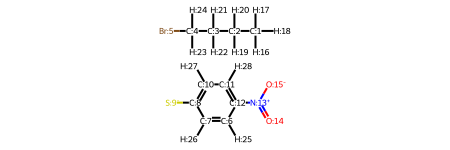

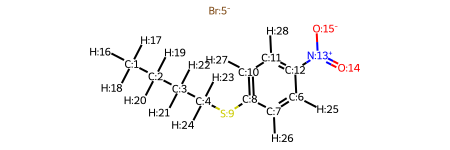

[C:0]([C:1]([C:2]([C:3]([Br:4])([H:22])[H:23])([H:20])[H:21])([H:18])[H:19])([H:15])([H:16])[H:17].[c:5]1([H:24])[c:6]([H:25])[c:7]([S-:8])[c:9]([H:26])[c:10]([H:27])[c:11]1[N+:12](=[O:13])[O-:14]>>[Br-:4].[C:0]([C:1]([C:2]([C:3]([S:8][c:7]1[c:6]([H:25])[c:5]([H:24])[c:11]([N+:12](=[O:13])[O-:14])[c:10]([H:27])[c:9]1[H:26])([H:22])[H:23])([H:20])[H:21])([H:18])[H:19])([H:15])([H:16])[H:17]


In [42]:
def make_rxn_from_idx(reactant_smi, atom_center_id, leaving_group_id):
    '''
    Input:
        reactant_smi: atom-indexed SMILES string with r1 and r2 SMILES, indexed starting at 0
        atom_center_id: electrophile atom index where the nucleophle is attacking
        leaving_group_id: group attached to the atom center that leaves after the nucleophile attacks
    Output:
        mol object including the products for the reaction.
    '''
    params = Chem.SmilesParserParams()
    params.removeHs = False
    
    r1, r2 = reactant_smi.split(".")
    r1_mol = Chem.MolFromSmiles(r1, params)
    r2_mol = Chem.MolFromSmiles(r2, params)
    
    # Get the anion atom  in the nucleophile

    combo = Chem.CombineMols(r1_mol, r2_mol)
    edcombo = Chem.EditableMol(combo)

#    updated_nuc_idx = combo.GetAtoms()[nuc_idx].GetIdx()
#    for atom in combo.GetAtoms():
#        print(f"{atom.GetIdx()} | {atom.GetAtomicNum()}")
    for atom in combo.GetAtoms():
        if atom.GetFormalCharge() < 0:
            nuc_idx = atom.GetIdx()
            break        
        
    edcombo.RemoveBond(atom_center_id - 1, leaving_group_id - 1)
    edcombo.AddBond(atom_center_id - 1 , nuc_idx, order=Chem.rdchem.BondType.SINGLE)
    
    back_mol = edcombo.GetMol()
    back_mol.GetAtoms()[leaving_group_id - 1].SetFormalCharge(-1)
    back_mol.GetAtoms()[nuc_idx].SetFormalCharge(0)
#    back_mol.__sssAtoms = [nuc_idx] # highlight the nucleophilic group
    
    final_rxn = reactant_smi + ">>" + Chem.MolToSmiles(back_mol)
    
    display(Chem.MolFromSmiles(reactant_smi, params))
    display(back_mol)
    return final_rxn
  

zero_idx_smi =  make_rxn_from_idx(zero_idx_smi_precursor, 4, 5)
zero_idx_smi = adjust_atom_map_smi_indexing(zero_idx_smi, mode="minus_one")
#zero_idx_smi =  make_rxn_from_idx(zero_idx_smi_precursor, 1, 2)
print(zero_idx_smi)

In [ ]:
# # H abstraction example
# zero_idx_smi = '[H:10][C:15]([H:11])([H:12])[C:16]([H:13])([H:14])[F:17].[H:0][C:5]([H:1])([H:2])[S:9][C:6]([H:3])([H:4])[O:8][O:7]>>[H:11][C:15]([H:12])[C:16]([H:13])([H:14])[F:17].[H:0][C:5]([H:1])([H:2])[S:9][C:6]([H:3])([H:4])[O:8][O:7][H:10]'
# one_idx_smi = '[H:11][C:16]([H:12])([H:13])[C:17]([H:14])([H:15])[F:18].[H:1][C:6]([H:2])([H:3])[S:10][C:7]([H:4])([H:5])[O:9][O:8]>>[H:12][C:16]([H:13])[C:17]([H:14])([H:15])[F:18].[H:1][C:6]([H:2])([H:3])[S:10][C:7]([H:4])([H:5])[O:9][O:8][H:11]'

# examples
# zero_idx_smi = "[C:0]([C:1]([C:2]([C:3]([Br:4])([H:12])[H:13])([H:10])[H:11])([H:8])[H:9])([H:5])([H:6])[H:7].[c:14]1([H:24])[c:15]([H:25])[c:16]([S-:17])[c:18]([H:26])[c:19]([H:27])[c:20]1[N+:21](=[O:22])[O-:23]>>[C:0]([C:1]([C:2]([C:3]([H:12])([H:13])[S:17][c:16]1[c:15]([H:25])[c:14]([H:24])[c:20]([N+:21](=[O:22])[O-:23])[c:19]([H:27])[c:18]1[H:26])([H:10])[H:11])([H:8])[H:9])([H:5])([H:6])[H:7].[Br-:4]"
zero_idx_smi = "[C:0]([C:1]([C:2]([C:3]([Br:4])([H:22])[H:23])([H:20])[H:21])([H:18])[H:19])([H:15])([H:16])[H:17].[c:5]1([H:24])[c:6]([H:25])[c:7]([S-:8])[c:9]([H:26])[c:10]([H:27])[c:11]1[N+:12](=[O:13])[O-:14]>>[C:0]([C:1]([C:2]([C:3]([S:8][c:7]1[c:6]([H:25])[c:5]([H:24])[c:11]([N+:12](=[O:13])[O-:14])[c:10]([H:27])[c:9]1[H:26])([H:22])[H:23])([H:20])[H:21])([H:18])[H:19])([H:15])([H:16])[H:17].[Br-:4]"

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdChemReactions as Reactions
from rdkit.Chem.Draw import IPythonConsole
from PIL import Image

rxn = Reactions.ReactionFromSmarts(zero_idx_smi, useSmiles=True)
Draw.ReactionToImage(rxn, subImgSize=(600, 600))


In [ ]:
# this function calcualte R-H bond distances for closed-shell reactant/product species based on averaging of N conformers embedded from force field 
# a helper function used in gen_ts
def return_opt_spc_bond_distance(
    spc_smi,
    pivot_atom,
    the_h_atom,
    atom_map_idx,    
    averaged = 5,
    ):

    """
    Return the optimized bond distance of reacting R-H from reactant/product species. Only use on non-radical RH species. 
    """
    
    bd_list = list()
    
    while averaged:
        r = RDKitMol.FromSmiles(spc_smi)
        ff = RDKitFF('mmff94s')
        r.EmbedConformer(FF)
        ff.setup(r)
        ff.optimize()
        m = ff.get_optimized_mol()

        r_conf = r.GetConformer()
        r_conf.SetPositions(m.GetPositions())

        h_idx = atom_map_idx.index(the_h_atom)
        pivot_idx = atom_map_idx.index(pivot_atom)

        bd = r_conf.GetBondLength([h_idx, pivot_idx])
        bd_list.append(bd)
        averaged -= 1
        
    return sum(bd_list)/len(bd_list)   

In [ ]:
def initialize_ts_guess_geometry(
    empirical_para_dict,
    species_complex_dict,
):
    
    _reactants, _products = split_rxn_smi(rxn_smi=species_complex_dict['rxn_smi'])    
    ts_conformer = species_complex_dict['ts_complex'].GetConformer()
    
    # set TS bond distances
    # update bond distance of r1 -- H(ts)
    # step 1: find the reacting bond distance of r1 when it's not in the TS based on averaging of 10 conformers 
    r1_dist = return_opt_spc_bond_distance(spc_smi = _reactants[0],
                            pivot_atom = species_complex_dict['ts_pivot_indices'][0],
                            the_h_atom = species_complex_dict['ts_h_index'][0],
                            atom_map_idx = species_complex_dict['r_fragment_indices'][0],  
                            )
    
    # step 2: scale the reacting bond with a scaling factor, the factor is provided by user currently, but it can be learned since it depends on reactant/product type (usually 25% is good starting guess for C-H, 15% for O-H etc)
    bond_length_X_H = r1_dist * empirical_para_dict['bond_length_scale_factor_r1']
    
    # step 3: set bond length for the TS complex 
    ts_conformer.SetBondLength([species_complex_dict['ts_pivot_indices'][0], 
                                                      species_complex_dict['ts_h_index'][0],
                                                      ], 
                                                     bond_length_X_H)
    
    # update bond distance of H(ts) -- r2
    r2_dist = return_opt_spc_bond_distance(spc_smi = _products[0], # note, this was changed
                            pivot_atom = species_complex_dict['ts_pivot_indices'][1],
                            the_h_atom = species_complex_dict['ts_h_index'][0], 
                            atom_map_idx = species_complex_dict['p_fragment_indices'][0], # note, this was changed 
                            )
    

    bond_length_H_Y = r2_dist * empirical_para_dict['bond_length_scale_factor_r2']
    
    ts_conformer.SetBondLength([species_complex_dict['ts_pivot_indices'][1], 
                                                      species_complex_dict['ts_h_index'][0],
                                                      ], 
                                                     bond_length_H_Y)
    
     
    # set TS angle
    ts_conformer.SetAngleDeg([species_complex_dict['ts_pivot_indices'][0], 
                                                    species_complex_dict['ts_h_index'][0], 
                                                    species_complex_dict['ts_pivot_indices'][1]], 
                                                    empirical_para_dict['angle_X_H_Y']) # angle_X_H_Y can be learned, but usually 160 deg is good for most bi-mol H abs family
    
    # set TS dihedral
    # note: there are two sets of dihedrals for the TS, since a dihedral is defined by 4 connecting atoms, and there are 5 atoms connected in the TS region, thus 2 sets of dihedrals 
      
    # set dihedrals
    # note: the dihedrals can actually be searched or learned, but not implemented yet, currently we set to user provided value
    if len(species_complex_dict['r1_neighbour_indices']) > 0:
        ts_conformer.SetTorsionDeg([species_complex_dict['r1_neighbour_indices'][0], 
                                                          species_complex_dict['ts_pivot_indices'][0], 
                                                          species_complex_dict['ts_h_index'][0], 
                                                          species_complex_dict['ts_pivot_indices'][1],
                                                          ], 
                                                         empirical_para_dict['dihedral_r1'])
    if len(species_complex_dict['r2_neighbour_indices']) > 0:
        ts_conformer.SetTorsionDeg([species_complex_dict['ts_pivot_indices'][0], 
                                                          species_complex_dict['ts_h_index'][0], 
                                                          species_complex_dict['ts_pivot_indices'][1],
                                                          species_complex_dict['r2_neighbour_indices'][0], 
                                                          ], 
                                                         empirical_para_dict['dihedral_r2'])

    return species_complex_dict

In [ ]:
# this function check if the TS guess has atoms colliding with each other
# 0.4 anstrom is an empirical parameter 
def check_hard_collision(ts, threshold=0.4):
    if ts.HasCollidingAtoms(threshold=threshold):
        raise ValueError('Atom collision detected.')

In [ ]:
# a helper function to optimize the transition state using force field
# note: this is a constrained optimization that fixes the two TS bond distances first, 
# then, we optimize the geometry to a stable point to relax it (not to a saddle point as in typical ts search)
# the idea here is to relax each fragment of the ts to make the geometry more reasonable 
def opt_ts_ff(species_complex_dict):
    
    ts_complex = species_complex_dict['ts_complex']
    ts_conformer = ts_complex.GetConformer()
    
    bond_length_X_H = ts_conformer.GetBondLength(species_complex_dict['broken_bond'][0]) 
    bond_length_H_Y = ts_conformer.GetBondLength(species_complex_dict['formed_bond'][0]) 
        
    ff = RDKitFF('mmff94s')
    fake_ts = RDKitMol.FromSmiles(species_complex_dict['rxn_smi'].split('>>')[0])
    fake_ts.EmbedConformer()
    fake_ts.SetPositions(ts_complex.GetPositions())
    ff.setup(fake_ts)
    
    the_h_atom = species_complex_dict['ts_h_index'][0]
    pivot_atom_r1 = species_complex_dict['ts_pivot_indices'][0]
    pivot_atom_r2 = species_complex_dict['ts_pivot_indices'][1]
    
    ff.add_distance_constraint(atoms=[the_h_atom,pivot_atom_r1], value=bond_length_X_H)
    ff.add_distance_constraint(atoms=[the_h_atom,pivot_atom_r2], value=bond_length_H_Y)
    
    ff.optimize()
    m = ff.get_optimized_mol()
    
    ts_new = copy.deepcopy(ts_complex)
    ts_new.SetPositions(m.GetPositions())
    
    return ts_new 

In [ ]:
# this function check if two parts of the TS are too close to each other
# since the TS bond distance is about 1.3 anstrom for C-H, if two fragements are closer than this, additional bonds may form (collision)
def check_fragment_collision(ts, h_idx, threshold=1.3):
    distance_matrix = np.triu(ts.GetDistanceMatrix())
    index = h_idx # atom index of the ts h
    fragment_bond_distance_matrix = distance_matrix[0:index, index:] # check if two fragments are too close to each other 
    if np.any(fragment_bond_distance_matrix < threshold):
        raise ValueError('Reactants collision detected.')
    else:
        small_distances = fragment_bond_distance_matrix[fragment_bond_distance_matrix < 2]
        relax_score = np.sum((small_distances-2)**2) + np.min(small_distances) + np.max(fragment_bond_distance_matrix) + np.median(fragment_bond_distance_matrix) + np.average(fragment_bond_distance_matrix)
        relax_score = relax_score / (5 * np.max(fragment_bond_distance_matrix))
        return relax_score # notice that we return a score where the larger the score, the more seperated the two fragments of the TS are (ideal for initial guess)
    
def check_dihedral(ts, h_idx, torsion_pivot):
    ts_pivot = h_idx + torsion_pivot
    angle_deg = ts.GetConformer().GetAngleDeg(ts_pivot)
    return angle_deg

In [ ]:
def generate_bi_habs_ts_guess(          
           rxn_smi, 
           empirical_para_dict,
):
    """
    generate_bi_habs_ts_guess _summary_

    _extended_summary_

    Args:
        rxn_smi (_type_): _description_
        angle_X_H_Y (_type_): _description_
        dihedral_r1 (_type_): _description_
        dihedral_r2 (_type_): _description_
        bond_length_scale_factor_r1 (_type_): _description_
        bond_length_scale_factor_r2 (_type_): _description_
        bond_length_X_H (_type_, optional): _description_. Defaults to None.            
        bond_length_H_Y (_type_, optional): _description_. Defaults to None.
    """

    # perceive reaction and generate reactants, products, and TS complexes
    species_complex_dict = perceive_rxn_generate_complex(rxn_smi=rxn_smi)
    
    # initialize ts guess geometry
    species_complex_dict = initialize_ts_guess_geometry(    
        empirical_para_dict = empirical_para_dict, 
        species_complex_dict = species_complex_dict,)
    
    # optimize ts guess
    ts_new = opt_ts_ff(species_complex_dict=species_complex_dict)
    
#    check_hard_collision(ts_new) # note this doesn't work for iodine (only up to n=36)
    
    bond_length_X_H = ts_new.GetConformer().GetBondLength(species_complex_dict['broken_bond'][0]) 
    bond_length_H_Y = ts_new.GetConformer().GetBondLength(species_complex_dict['formed_bond'][0]) 
        
    threshold = min([bond_length_X_H, bond_length_H_Y]) * 0.5 # Note, this was decreased from previously.
#    relax_score = check_fragment_collision(ts_new, species_complex_dict['ts_h_index'][0], threshold=threshold)
    relax_score = check_dihedral(ts_new, 
                                 species_complex_dict['ts_h_index'],
                                 species_complex_dict['ts_pivot_indices']
                                )
    return relax_score, ts_new, species_complex_dict  


# print(EMPIRICAL_PARA_TS_GUESS)
# a, b, c = generate_bi_habs_ts_guess(zero_idx_smi, EMPIRICAL_PARA_TS_GUESS)
# display(b)

In [ ]:
# a helper function to attempt to generate N valid TS guesses, each with a score upto some max iteration 
# expensive step, can be optimized 
def gen_n_ts_confs(
           rxn_smi,
           empirical_para_dict,
           num_confs = 10,
           max_total_iter = 50,
):
    
    result = list()
    result_count = len(result)
    
    iter_counter = 0
    while result_count < num_confs and iter_counter < max_total_iter:
        try:
            relax_score, ts_new, species_complex_dict = generate_bi_habs_ts_guess(rxn_smi=rxn_smi, empirical_para_dict=empirical_para_dict)
            if all([relax_score, ts_new]):
                xyz = ts_new.ToXYZ()
                g_xyz = "\n".join([l for l in xyz.splitlines()[2:]]) + "\n\n"
                result.append(tuple([relax_score, g_xyz])) 
        except:
            pass
        finally:
            iter_counter += 1
            result_count = len(result)
    
    if not result:
        raise ValueError('Failed to generate TS conformers.')
    else:
        result.sort(key=lambda y:y[0])
        
    output = dict()
    output = copy.deepcopy(species_complex_dict)
    del output['r_complex']
    del output['p_complex']
    del output['ts_complex']
    result_g_xyz = [x[-1] for x in result]
    score_dist = [x[0] for x in result]
    ts_conformers_coord = tuple([(k, v) for k, v in zip(score_dist, result_g_xyz)])
    output['ts_conformers_coord'] = ts_conformers_coord
    
    return output

In [ ]:
output = gen_n_ts_confs(
           rxn_smi = zero_idx_smi,
           empirical_para_dict = EMPIRICAL_PARA_TS_GUESS,
           num_confs = 10,
           max_total_iter = 20,
)

In [ ]:
print(output['ts_conformers_coord'][0][1])

In [ ]:
# write to json file
with open("ts_guess.json", "w") as outfile:
    json.dump(output, outfile)

In [ ]:
def xyz_string_to_np_array(input_str):
    # Using a regular expression to extract all floating point numbers from the string
    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", input_str)
    
    # Converting the list of strings to a list of floats
    numbers = [float(num) for num in numbers]
    
    # Reshaping the list into an array of shape (N, 3), where N is the number of atoms
    return np.array(numbers).reshape(-1, 3)

In [ ]:
def reconstruct_complex(rxn_smi, fbond, ts_xyz_str=None):
    """
    This function reconstruct r_complex, p_complex, and ts_complex from atom-mapped reaction smiles.
    """
    
    r_complex, p_complex = [RDKitMol.FromSmiles(smi) for smi in rxn_smi.split(">>")]
    
    r_complex.EmbedConformer(FF) # here we use ETKDGv3() defined on top of the notebook, but can be changed to others if needed
    p_complex.EmbedConformer(FF)
    
    ts_complex = r_complex.AddRedundantBonds(fbond) # we need to add redundant bond to the reactant complex graph to represent the TS geometry 
    
    if ts_xyz_str:
        ts_xyz_array = xyz_string_to_np_array(ts_xyz_str)
        ts_complex.SetPositions(ts_xyz_array)
    
    return r_complex, p_complex, ts_complex 

In [ ]:
r_complex, p_complex, ts_complex = reconstruct_complex(
    rxn_smi=output['rxn_smi'],
    fbond=output['formed_bond'],
    ts_xyz_str=output['ts_conformers_coord'][0][-1]
)

In [ ]:
ts_viewer(r_complex, p_complex, ts_complex, only_ts=True)

In [ ]:
r_complex, p_complex, ts_complex = reconstruct_complex(
    rxn_smi=output['rxn_smi'],
    fbond=output['formed_bond'],
    ts_xyz_str=output['ts_conformers_coord'][-1][-1]
)

In [ ]:
ts_viewer(r_complex, p_complex, ts_complex, only_ts=True)